In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from tqdm.notebook import tqdm
import pickle as pkl

# Dataset download and extraction

In [ ]:
!curl -L -o ./emnist.zip https://www.kaggle.com/api/v1/datasets/download/crawford/emnist

In [ ]:
!unzip emnist.zip -d emnist

# Dataset load

The dataset is loaded using the pandas library. The first row of the csv contains the index of the class. The list of classes can be found in the file `emnist-balanced-mapping.txt`, which is loaded. The dataset is already split into training and training sets, and the images are squeezed into a single row: each pixel has its own column. The images are 28x28 pixels, so there are 784 + 1 columns in each .csv file.

After the dataset is loaded, we print the number of istances.

In [2]:
# load emnist balanced data
labels = pd.read_csv(    'emnist/emnist-balanced-mapping.txt', delimiter=' ', index_col=0, header=None)
train_data = pd.read_csv('emnist/emnist-balanced-train.csv', header=None)
test_data = pd.read_csv( 'emnist/emnist-balanced-test.csv', header=None)

print("train_data len:", len(train_data))
print("test_data len:", len(test_data))

train_data len: 112800
test_data len: 18800


## Parsing labels datatable

The labels are saved in the `emnist-balanced-mapping.txt` file, which contains the mapping between the class index and the class character.
After the file is loaded, we convert the numbers of the classes to the corresponding characters.

In [ ]:
# convert the labels column 1 from int to char, rename the column as char
labels['char'] = labels[1].apply(lambda x: chr(x))
# drop the original int column
labels = labels.drop(1, axis=1)

Using the `labels` dataframe, we can convert the classes index in the datasets dataframes into characters.

In [ ]:
# Move the labels to the last column
train_data['label'] = train_data[0]
# Remove the original labels column
train_data = train_data.drop(0, axis=1)
# Convert the labels to chars
train_data['label'] = train_data['label'].apply(lambda x: labels.loc[x].char)

# Move the labels to the last column
test_data['label'] = test_data[0]
# Remove the original labels column
test_data = test_data.drop(0, axis=1)
# Convert the labels to chars
test_data['label'] = test_data['label'].apply(lambda x: labels.loc[x].char)

A couple of functions are defined to handle the images from the dataframes.

`get_image_data()` takes a row from the dataset and returns the image normalized into the range [0, 1].

`data_to_image()` allows to reshape the image data into a 28x28 matrix, useful to the plot.

In [ ]:
def get_image_data(dataframe, i):
    """
    Get the image data from the dataframe at row i and normalize it

    Args:
        dataframe: pd.DataFrame
        i: int, the row index

    Returns:
        img: np.array, the image data
    """
    # get only the columns 1 ~ 784
    img = dataframe.iloc[i, :-1].values
    img /= 255
    return img

def data_to_image(data):
    """
    Reshape the data to image

    Args:
        data: np.array, the data

    Returns:
        img: np.array, the image
    """
    img = data.reshape(-1, 28, 28).T
    img = np.array(img, dtype=np.float32)
    return img

## Dataset analysis

Then we can plot an image for each class, to see how the images look like.

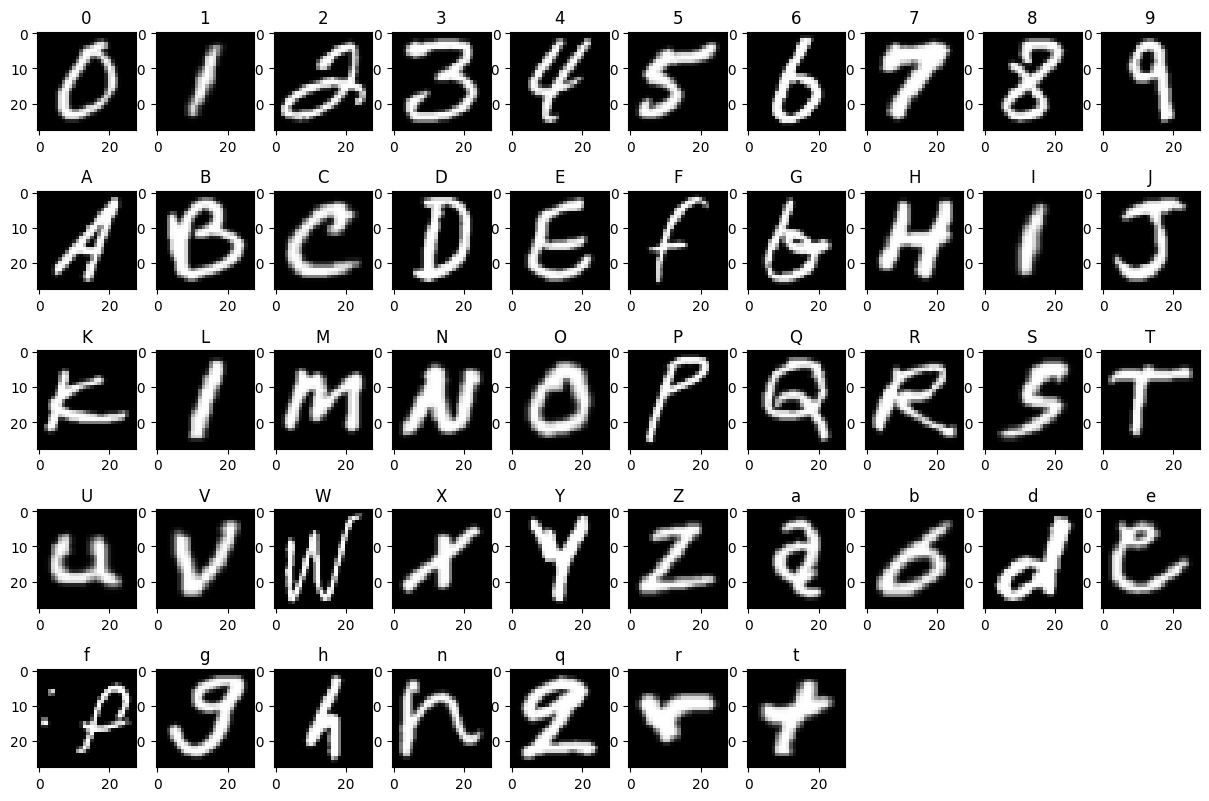

In [ ]:
fig = plt.figure(figsize=(15, 10))
columns = 10
rows = 5

for i in range(len(labels)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(labels.loc[i].char)
    first_index = train_data[train_data.label == labels.loc[i].char].index[0]
    img = get_image_data(train_data, first_index)
    img = data_to_image(img)
    plt.imshow(img, cmap='gray')

We can plot the distribution of the classes in the training set, to see if the dataset is balanced.

<Axes: xlabel='label'>

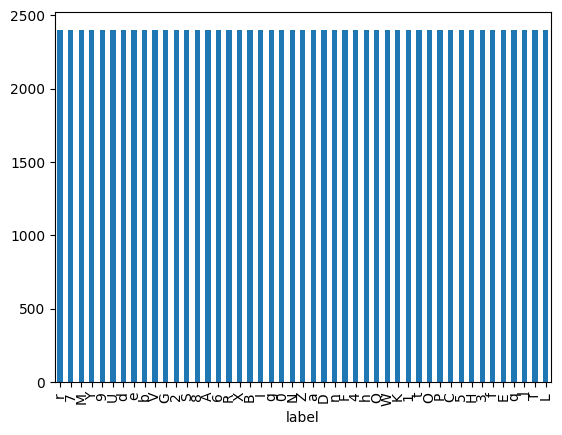

In [ ]:
# show the distribution of the classes
train_data['label'].value_counts().plot(kind='bar')

# Model Training

The train and test dataframes are converted into numpy arrays, meanwhile the images are normalized into the range [0, 1].
The resulting matrix will have shape (n_samples, 784), where n_samples is the number of images in the dataset split.

In [15]:
# from train_data, get all the rows, parse them with get_image_data, and append them to the list
train_images = np.array([get_image_data(train_data, i) for i in range(len(train_data))])
train_labels = train_data['label']

# from test_data, get all the rows, parse them with get_image_data, and append them to the list
test_images = np.array([get_image_data(test_data, i) for i in range(len(test_data))])
test_labels = test_data['label']

Some useful functions are defined to handle the training and testing of the models.

`train_pca()` trains a PCA model on the training data given the number of components, and returns the model.

`train_model()` trains a model from the sklearn library, returning the trained model.

`evaluate_model()` evaluates the model on the test data, returning the predictions and the metrics.

`train_and_evaluate_model()` trains a model, evaluates it and prints the metrics (it internally calls the previous functions).

In [16]:
def train_pca(X_train, Y_train, n_components=None):
    """
    Train PCA on the training data

    Args:
        X_train: np.array, the training data
        Y_train: np.array, the training labels
        n_components: int, the number of components to keep

    Returns:
        pca: PCA, the trained PCA model
        X_train_pca: np.array, the transformed training data
    """
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train, Y_train)
    return pca, X_train_pca

def train_model(model, X_train_pca, Y_train):
    """
    Train the model on the training data

    Args:
        model: model, the model to train
        X_train_pca: np.array, the training data
        Y_train: np.array, the training labels

    Returns:
        model: model, the trained model
    """
    model.fit(X_train_pca, Y_train)
    return model

def evaluate_model(pca, model, X_test, Y_test):
    """
    Evaluate the model on the test data

    Args:
        pca: PCA, the trained PCA model
        model: model, the trained model
        X_test: np.array, the test data
        Y_test: np.array, the test labels

    Returns:
        Y_pred: np.array, the predicted labels
        metrics: dict, the evaluation metrics, containing accuracy, precision, recall, and f1
    """
    X_test_pca = pca.transform(X_test)
    Y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    return Y_pred, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_and_evaluate_model(model, pca, X_train_pca, Y_train, X_test, Y_test):
    """
    Train and evaluate the model

    Args:
        model: model, the model to train
        pca: PCA, the trained PCA model
        X_train_pca: np.array, the training data
        Y_train: np.array, the training labels
        X_test: np.array, the test data
        Y_test: np.array, the test labels

    Returns:
        model: model, the trained model
        Y_pred: np.array, the predicted labels
        metrics: dict, the evaluation metrics (see evaluate_model)
    """
    model = train_model(model, X_train_pca, Y_train)
    Y_pred, metrics = evaluate_model(pca, model, X_test, Y_test)
    return model, Y_pred, metrics

A first model is trained using PCA to reduce the dimensionality of the data. Since we don't define any `n_components`, the model will keep all the components.

After the trianing it is used to reduce the dimensionality of the test data.

In [17]:
pca, X_train_pca = train_pca(train_images, train_labels)
y_test_pca = pca.transform(test_images)

After the PCA model is trained and the test data has been transformed, we can train the classification models and evaluate them.

The models used are:

- Logistic Regression
- K-Nearest Neighbors
- Random Forest

The results are saved in a dictionary, which is then saved into a pickle file to be used later.

In [ ]:
results = {}
for model_obj in tqdm([
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=11),
    RandomForestClassifier()
]):
    model, Y_pred, model_metrics = train_and_evaluate_model(
        model_obj,
        pca, X_train_pca, train_labels,
        test_images, test_labels
    )
    results[model_obj.__class__.__name__] = {
        'metrics': model_metrics,
        'predictions': Y_pred
    }

# save the results to a file with pickle
with open('results.pkl', 'wb') as f:
    pkl.dump(results, f)

We can then analyze how the number of components affects the performance of the task.
We train the models using different numbers of components, and then we save the results in a pickle file.

**WARNING: THIS CELL TAKES A LONG TIME TO RUN, SINCE IT TRAINS THE MODELS FOR ALL THE NUMBERS OF COMPONENTS. IT IS RECOMMENDED TO SKIP IT AND LOAD THE RESULTS FROM THE NEXT CELLS.**

In [ ]:
## COMPUTATIONALLY EXPENSIVE
## RUN THIS ONLY IF YOU HAVE TIME (MAY TAKE HOURS!)
# you can also load the results from the file with pickle with the next cells

results_components_10_100 = {}
start = 10
end = 100

if False:
    # load the results from the file with pickle
    with open('results_components_10_100.pkl', 'rb') as f:
        results_components_10_100 = pkl.load(f)

for n_component in tqdm(range(start, end)):

    current_run = {}

    pca, X_train_pca = train_pca(train_images, train_labels, n_component)
    y_test_pca = pca.transform(test_images)
    
    for model_obj in tqdm(
        [
            LogisticRegression(max_iter=1000),
            KNeighborsClassifier(n_neighbors=11),
            RandomForestClassifier()
        ],
        leave=False,
        desc=f'PCA components: {n_component}'
    ):
        model, Y_pred, model_metrics = train_and_evaluate_model(
            model_obj,
            pca, X_train_pca, train_labels,
            test_images, test_labels
        )
        current_run[model_obj.__class__.__name__] = {
            'metrics': model_metrics,
            'predictions': Y_pred
        }

    results_components_10_100[n_component] = current_run

    # save the results to a file with pickle (for every iteration)
    with open('results_components_10_100.pkl', 'wb') as f:
        pkl.dump(results_components_10_100, f)

# Results analysis

In [19]:
results = {}
with open('results.pkl', 'rb') as f:
    results = pkl.load(f)

In [33]:
results_components_10_100 = {}
with open('results_components_10_100.pkl', 'rb') as f:
    results_components_10_100 = pkl.load(f)

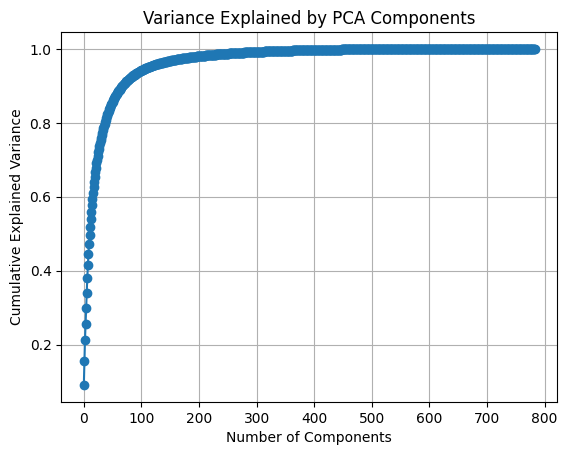

In [20]:
# Cumulative explained variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Variance Explained by PCA Components")
plt.grid()
plt.show()

In [ ]:
# final metrics
results_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
for model, metrics in results.items():
    row = pd.DataFrame({
        'model': [model],
        'accuracy': [metrics['metrics']['accuracy']],
        'precision': [metrics['metrics']['precision']],
        'recall': [metrics['metrics']['recall']],
        'f1': [metrics['metrics']['f1']]
    })
    results_df = pd.concat([results_df, row], ignore_index=True)

results_df

,model,accuracy,precision,recall,f1
0,LogisticRegression,0.686862,0.684927,0.686862,0.684765
1,KNeighborsClassifier,0.779574,0.793705,0.779574,0.779922
2,RandomForestClassifier,0.666011,0.662812,0.666011,0.657707


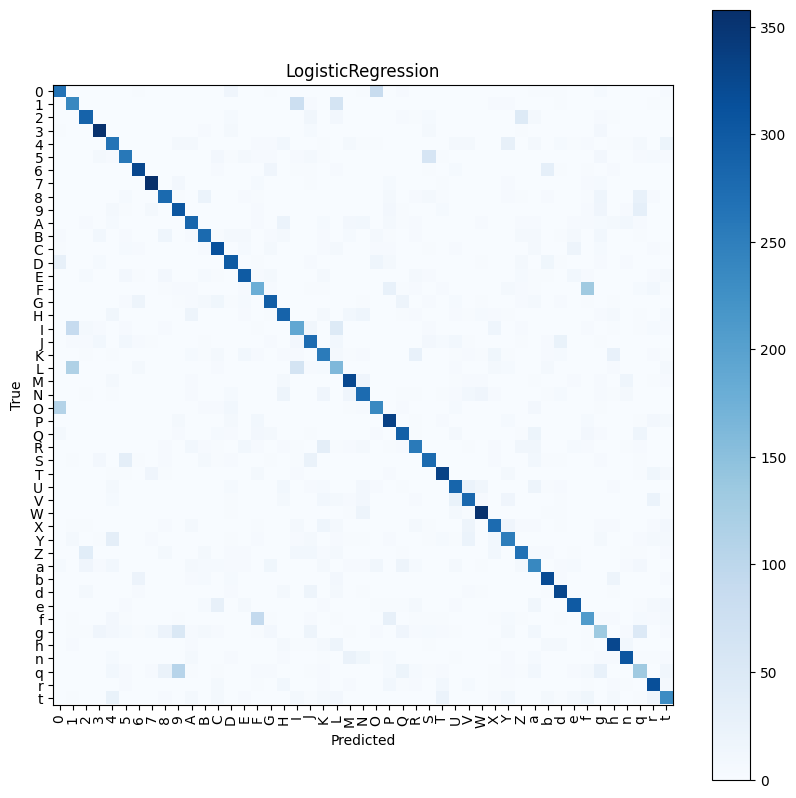

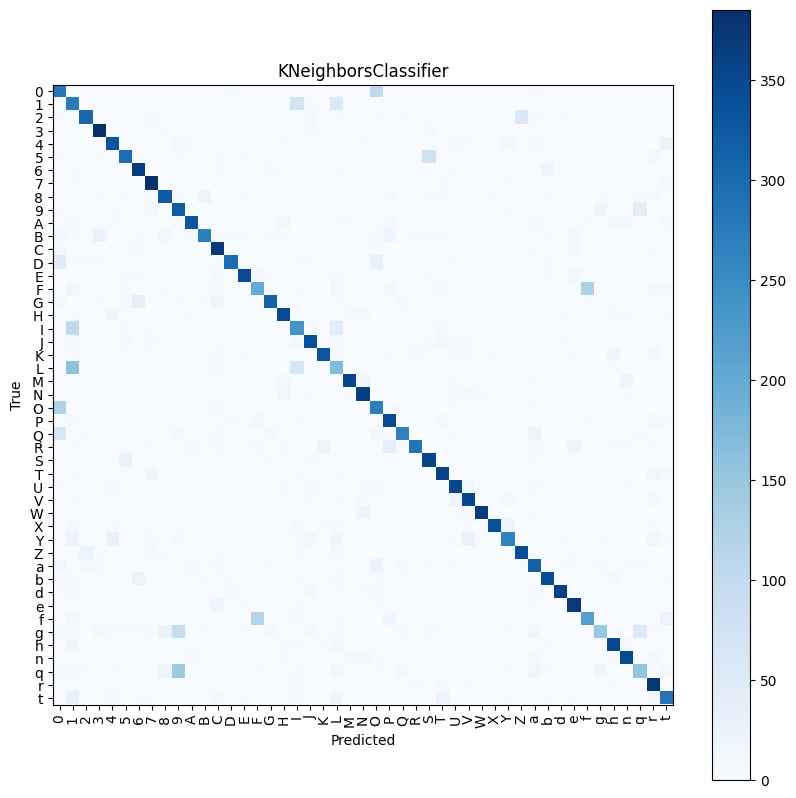

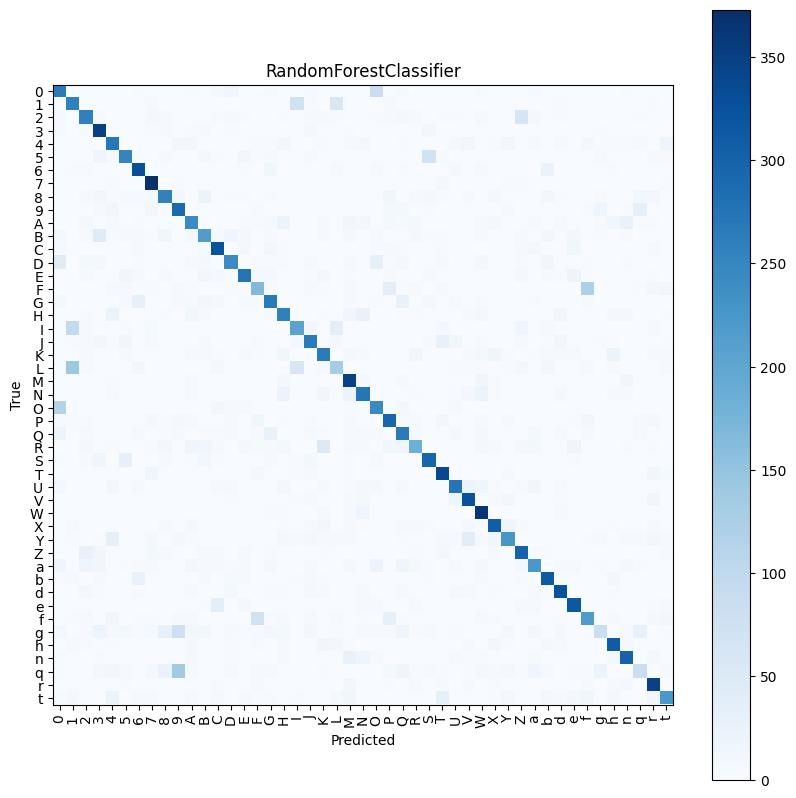

In [ ]:
# the confusion matrix for each model
for i, (model, metrics) in enumerate(results.items()):
    cm = confusion_matrix(test_labels, metrics['predictions'])
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, cmap='Blues')
    plt.title(model)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels)), labels['char'], rotation=90)
    plt.yticks(range(len(labels)), labels['char'])
    plt.colorbar()
    plt.show()

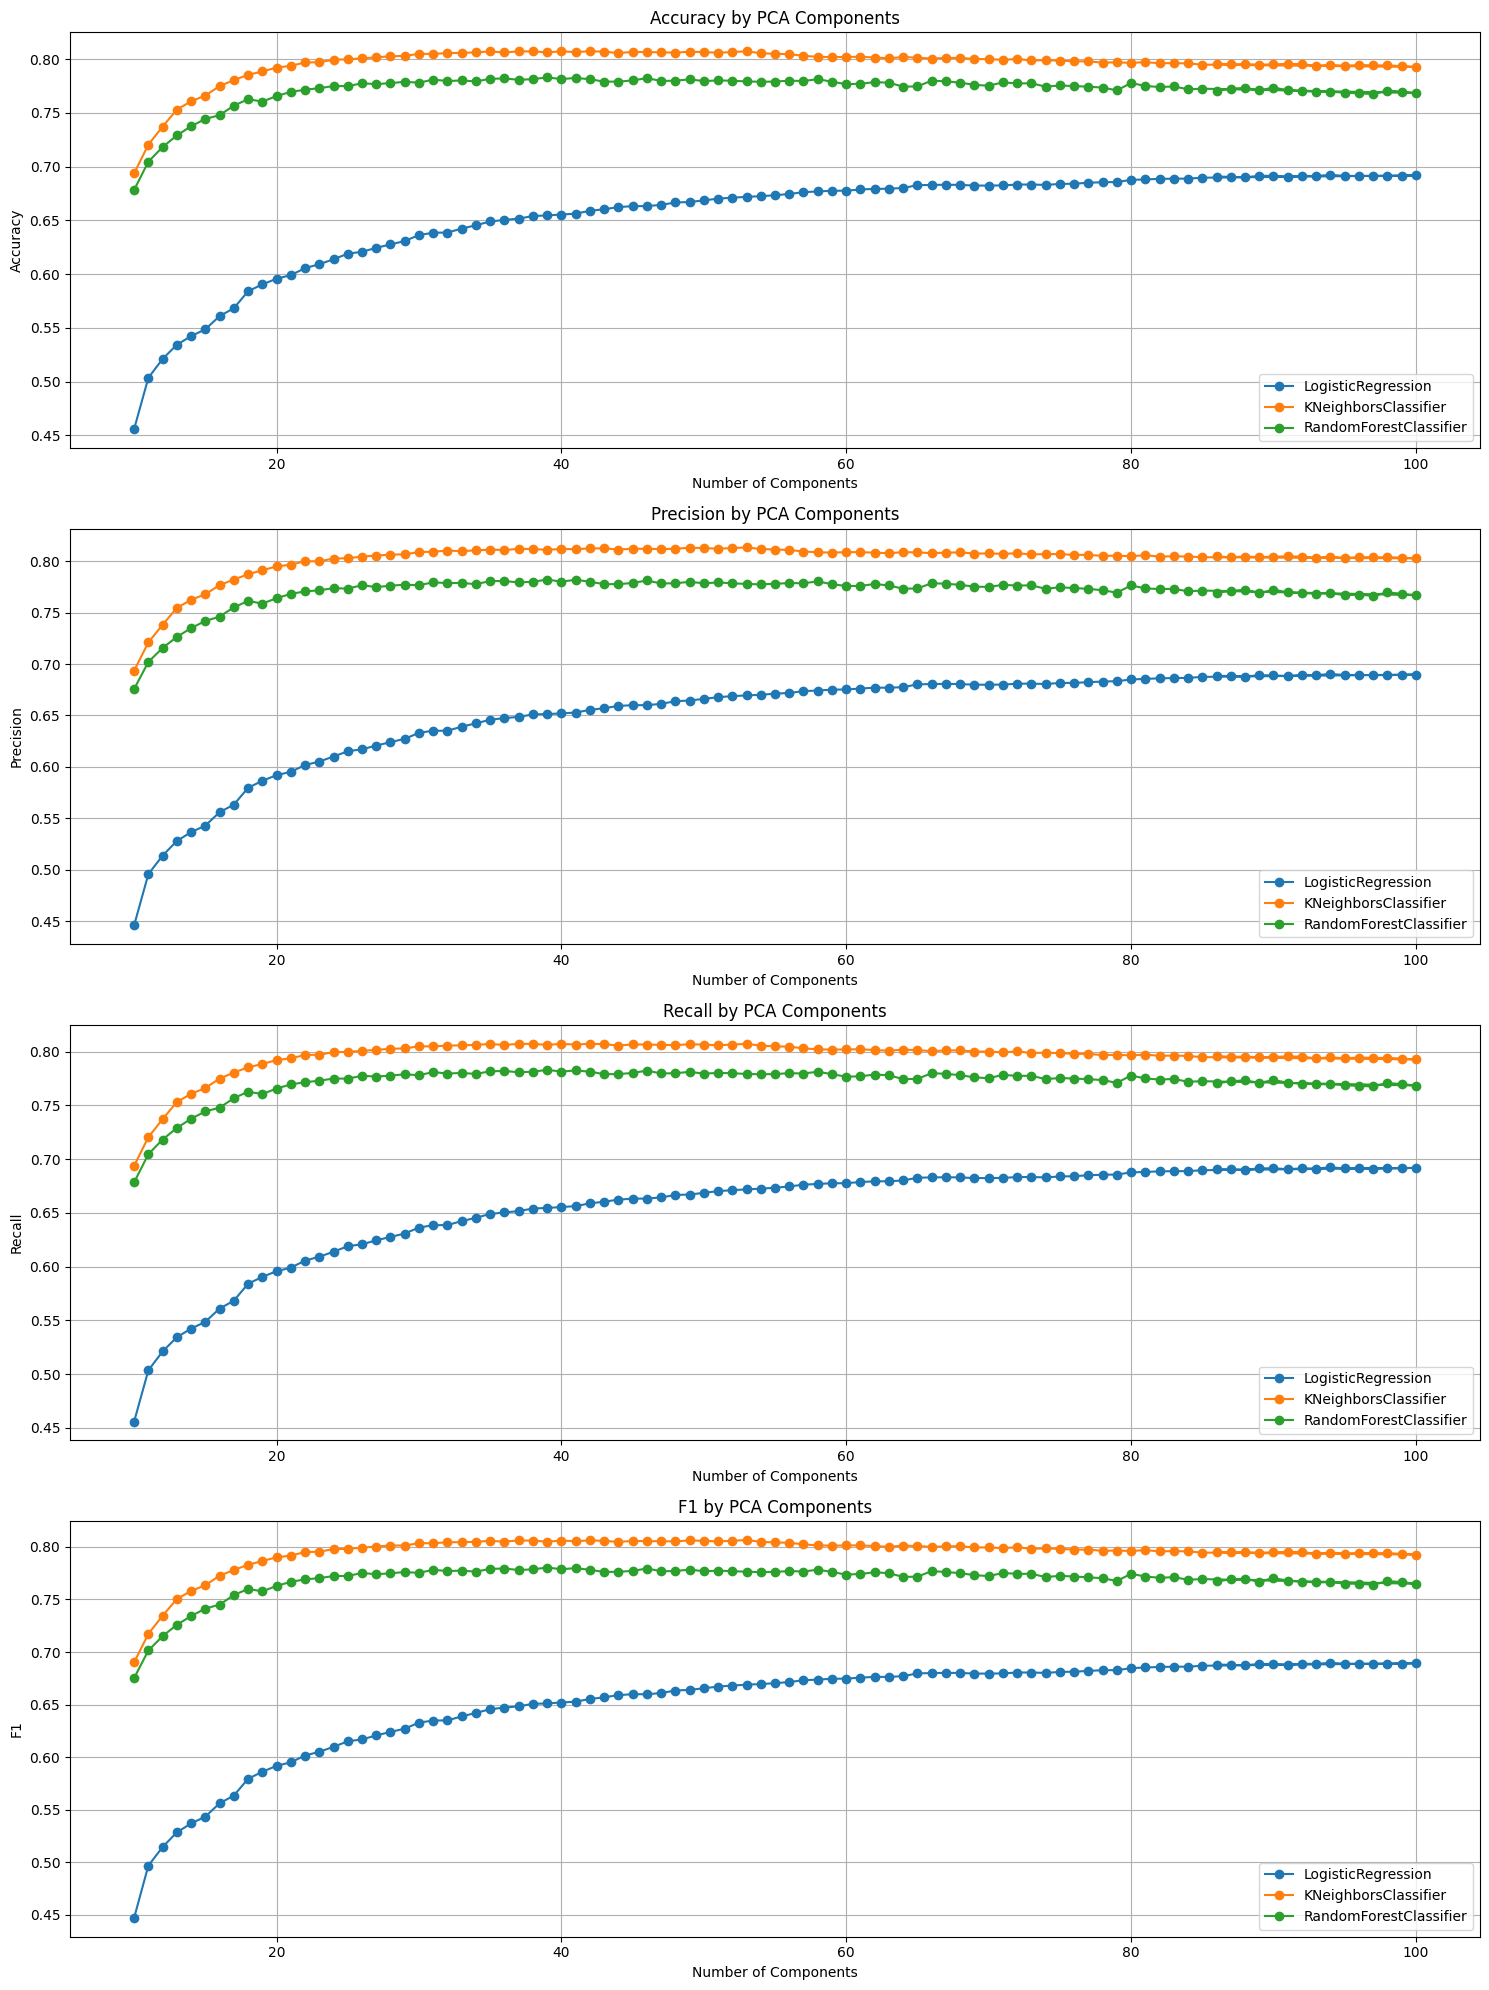

In [ ]:
# plot for each metrics (accuracy, precision, recall, f1) by PCA components
fig, ax = plt.subplots(4, 1, figsize=(15, 20))

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    data = {}
    for n_component in results_components_10_100:
        for model, metrics in results_components_10_100[n_component].items():
            if model not in data:
                data[model] = {}
            data[model][n_component] = metrics['metrics'][metric]

    df = pd.DataFrame(data)
    df.plot(ax=ax[i], marker='o')
    ax[i].set_xlabel("Number of Components")
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_title(f"{metric.capitalize()} by PCA Components")
    ax[i].grid()

plt.tight_layout()
plt.show()
